In [79]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from google.colab import drive
drive.mount('/content/drive')
RANDOM_STATE=1234

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
df = pd.read_csv('/content/drive/MyDrive/760/Final Data/House price/SA1.csv')
df = df.drop(labels=['Unnamed: 0'],axis=1)
df.head()

,SA12018_code,averge_room,Male,Female,Average Age,European,Māori,Pacific Peoples,Asian,Middle Eastern / Latin American / African,...,Employer,Self employed and without employees,Unpaid family worker,mean_CV,mean_FA,mean_AR,mean_bed,mean_Bath,mean_Price,mean_school
0,7001130,2.684211,0.580000,0.420000,41.423077,0.703125,0.265625,0.000000,0.000000,0.0,...,0.035714,382,0.017857,-0.792119,-1.116825,1.306734,-2.155759,-0.752181,12.577041,0.0
1,7001131,2.161290,0.547170,0.452830,50.076923,0.746032,0.142857,0.047619,0.015873,0.0,...,0.042553,364,0.042553,-0.758861,-1.324414,0.317926,-2.155759,-0.752181,12.396693,0.0
2,7001132,2.266667,0.568182,0.431818,48.190476,0.788462,0.173077,0.019231,0.019231,0.0,...,0.037037,535,0.018519,-1.062347,-1.324414,0.250772,-2.155759,-0.752181,12.013701,0.0
3,7001133,2.894737,0.534884,0.465116,48.162791,0.836735,0.102041,0.000000,0.020408,0.0,...,0.046512,392,0.023256,-0.607117,-1.988700,0.676994,-3.866658,-0.752181,12.236150,0.0
4,7001134,2.882353,0.640000,0.360000,51.130435,0.884615,0.038462,0.000000,0.000000,0.0,...,0.000000,527,0.000000,-0.530206,-1.179101,0.267217,-2.155759,-0.752181,12.706848,0.0


In [81]:
print(df.head(10))

   SA12018_code  averge_room      Male    Female  Average Age  European  \
0       7001130     2.684211  0.580000  0.420000    41.423077  0.703125   
1       7001131     2.161290  0.547170  0.452830    50.076923  0.746032   
2       7001132     2.266667  0.568182  0.431818    48.190476  0.788462   
3       7001133     2.894737  0.534884  0.465116    48.162791  0.836735   
4       7001134     2.882353  0.640000  0.360000    51.130435  0.884615   
5       7001135     2.310345  0.500000  0.500000    46.402985  0.717647   
6       7001136     2.066667  0.481481  0.518519    49.222222  0.774194   
7       7001137     3.222222  0.500000  0.500000    39.363636  0.742424   
8       7001138     3.562500  0.500000  0.500000    33.724138  0.680000   
9       7001139     3.238095  0.484375  0.515625    39.500000  0.828947   

      Māori  Pacific Peoples     Asian  \
0  0.265625         0.000000  0.000000   
1  0.142857         0.047619  0.015873   
2  0.173077         0.019231  0.019231   
3  0.1

In [82]:
Y = df["mean_Price"]
X = df.copy(True)
X = X.drop(labels=["mean_Price"],axis=1)
print(X.columns)

Index(['SA12018_code', 'averge_room', 'Male', 'Female', 'Average Age',
       'European', 'Māori', 'Pacific Peoples', 'Asian',
       'Middle Eastern / Latin American / African', 'Other Ethnicity',
       'New Zealander(19)', 'Other Ethnicity nec(19)',
       'Median personal income($)', 'Employed Full time', 'Employed Part time',
       'Unemployed', 'Paid employee', 'Employer',
       'Self employed and without employees', 'Unpaid family worker',
       'mean_CV', 'mean_FA', 'mean_AR', 'mean_bed', 'mean_Bath',
       'mean_school'],
      dtype='object')


In [83]:
def plot_model(model,data):
  core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
  core_samples_mask[model.core_sample_indices_] = True
  print(model.labels_)
  print(model)

  labels = model.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  #print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

  unique_labels = set(labels)
  print("unique_labels = {unique_labels}".format(unique_labels=unique_labels))
  colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k==-1 or k==0:
          # Black used for noise.
          #col = [0, 0, 0, 1]
          continue

      class_member_mask = labels == k

      xy = data[class_member_mask & core_samples_mask].to_numpy()
      #print(xy)
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=14,
      )

      xy = data[class_member_mask & ~core_samples_mask].to_numpy()
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=6,
      )

  plt.title("Estimated number of clusters: %d" % n_clusters_)
  plt.show()

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=50, min_samples=3, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 7912
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


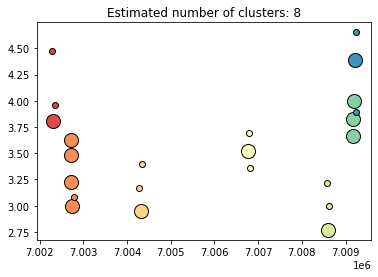

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=250, min_samples=15, n_jobs=20)
Estimated number of clusters: 12
Estimated number of noise points: 7730
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}


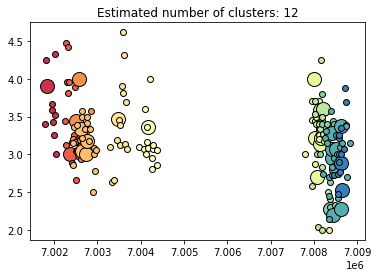

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=300, min_samples=20, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 7828
unique_labels = {0, 1, 2, 3, -1}


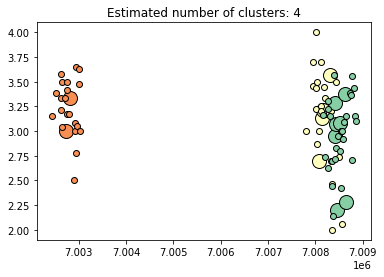

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=350, min_samples=25, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 7723
unique_labels = {0, 1, 2, 3, 4, -1}


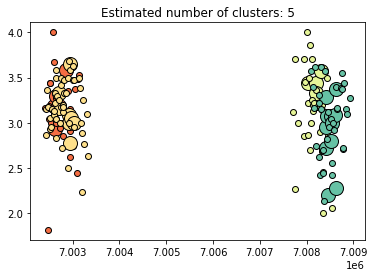

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=400, min_samples=30, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7700
unique_labels = {0, 1, 2, 3, 4, 5, -1}


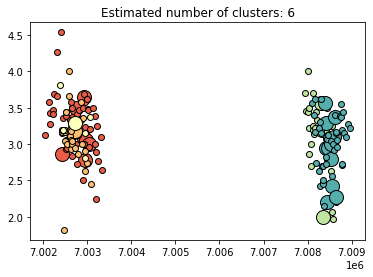

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=450, min_samples=35, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 7436
unique_labels = {0, 1, 2, 3, 4, 5, -1}


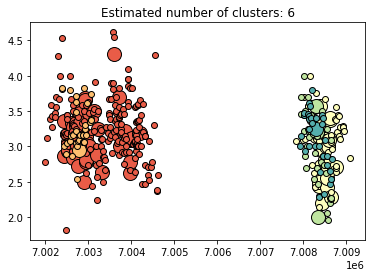

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=500, min_samples=10, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 561
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


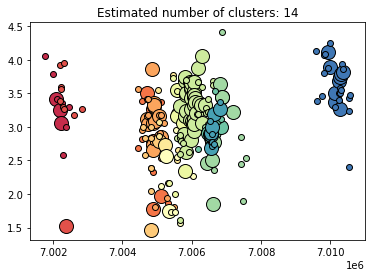

[ 2 -1  2 ...  0 13  0]
DBSCAN(eps=500, min_samples=15, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 1231
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


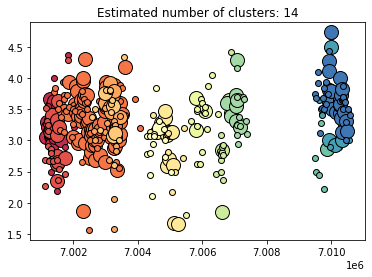

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=500, min_samples=40, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 7321
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


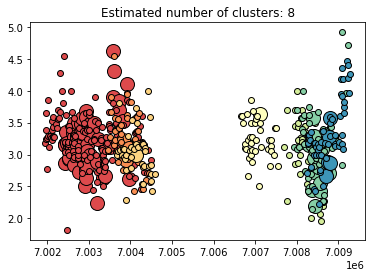

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=550, min_samples=10, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 405
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


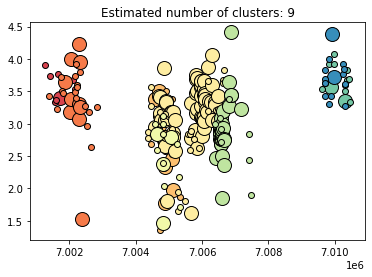

[ 2 -1  2 ...  0  0  0]
DBSCAN(eps=550, min_samples=15, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 777
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


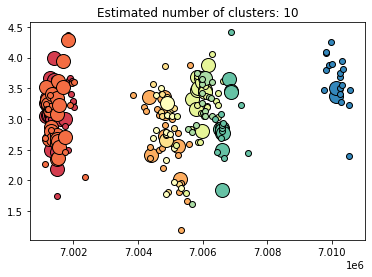

[ 2 -1  2 ...  1 -1  1]
DBSCAN(eps=550, min_samples=20, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 1408
unique_labels = {0, 1, 2, 3, 4, 5, -1}


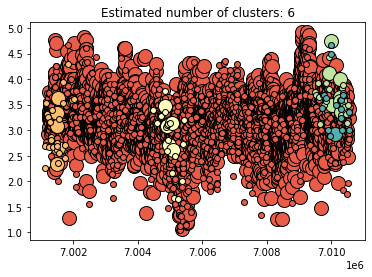

[-1 -1 -1 ... -1 -1  0]
DBSCAN(eps=550, min_samples=25, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 2169
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


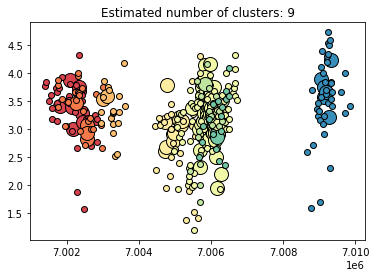

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=550, min_samples=50, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 7479
unique_labels = {0, 1, 2, 3, 4, -1}


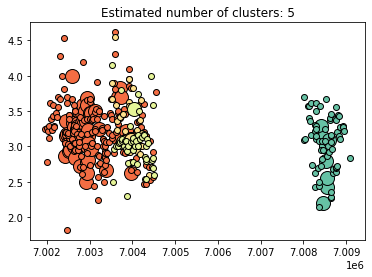

[0 1 0 ... 0 0 0]
DBSCAN(eps=600, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 155
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


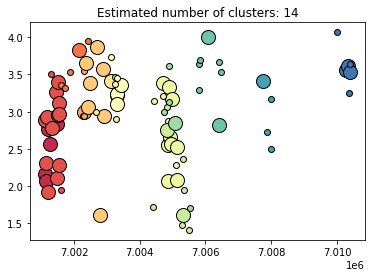

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=600, min_samples=10, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 338
unique_labels = {0, 1, 2, 3, -1}


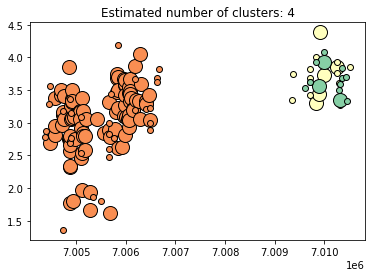

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=600, min_samples=15, n_jobs=20)
Estimated number of clusters: 9
Estimated number of noise points: 595
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


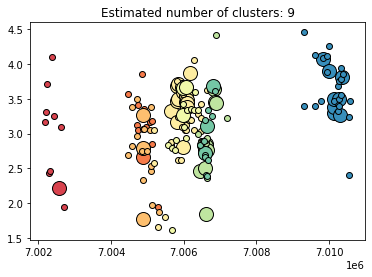

[ 2 -1  2 ...  0  0  0]
DBSCAN(eps=600, min_samples=20, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 1085
unique_labels = {0, 1, 2, 3, 4, 5, -1}


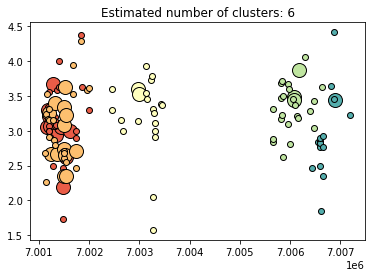

[-1 -1  1 ...  0 -1  0]
DBSCAN(eps=600, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 1637
unique_labels = {0, 1, 2, 3, -1}


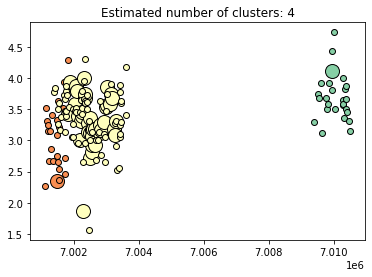

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=600, min_samples=30, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 2289
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


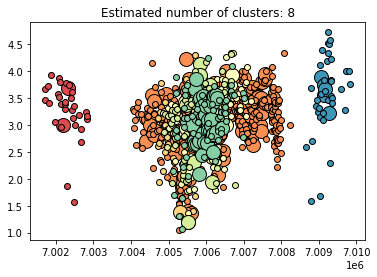

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=600, min_samples=35, n_jobs=20)
Estimated number of clusters: 14
Estimated number of noise points: 3278
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}


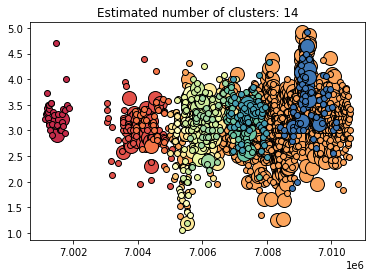

[0 1 0 ... 0 0 0]
DBSCAN(eps=700, n_jobs=20)
Estimated number of clusters: 10
Estimated number of noise points: 97
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


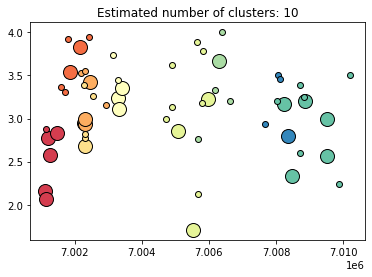

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=700, min_samples=15, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 385
unique_labels = {0, 1, 2, 3, 4, 5, -1}


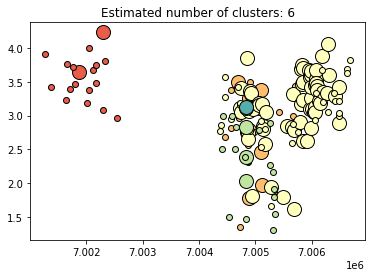

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=700, min_samples=20, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 570
unique_labels = {0, 1, 2, 3, 4, -1}


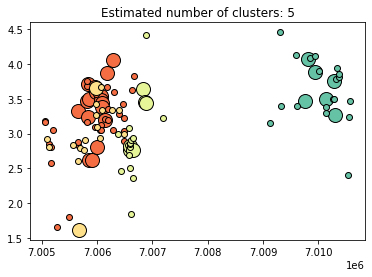

[ 1 -1  1 ...  0  0  0]
DBSCAN(eps=700, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 900
unique_labels = {0, 1, 2, 3, -1}


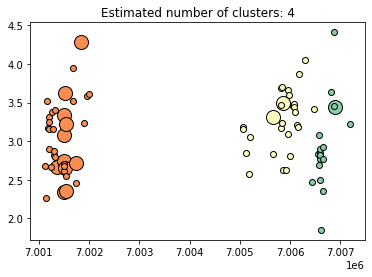

[-1 -1 -1 ... -1  3  0]
DBSCAN(eps=700, min_samples=35, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 1583
unique_labels = {0, 1, 2, 3, -1}


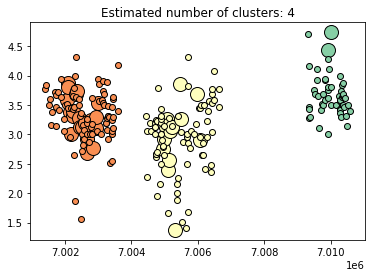

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=40, n_jobs=20)
Estimated number of clusters: 6
Estimated number of noise points: 2111
unique_labels = {0, 1, 2, 3, 4, 5, -1}


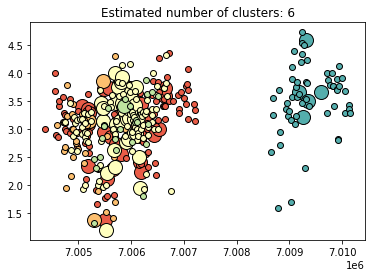

[-1 -1 -1 ... -1 -1 -1]
DBSCAN(eps=700, min_samples=50, n_jobs=20)
Estimated number of clusters: 8
Estimated number of noise points: 3770
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, -1}


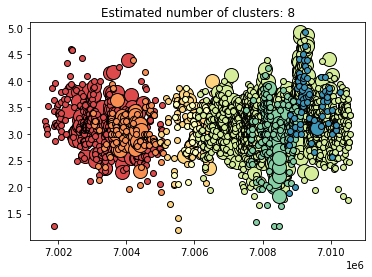

[0 1 0 ... 0 0 0]
DBSCAN(eps=800, min_samples=3, n_jobs=20)
Estimated number of clusters: 13
Estimated number of noise points: 37
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


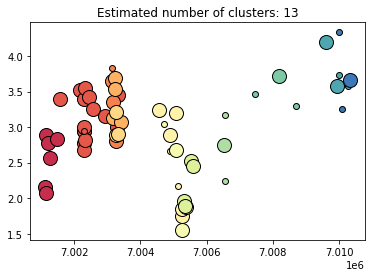

[0 1 0 ... 0 0 0]
DBSCAN(eps=800, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 79
unique_labels = {0, 1, 2, 3, 4, -1}


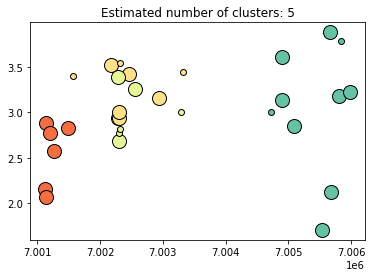

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=800, min_samples=20, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 400
unique_labels = {0, 1, 2, 3, -1}


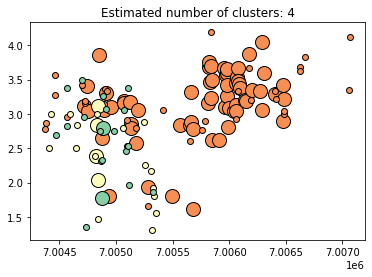

[ 0 -1  0 ...  0  0  0]
DBSCAN(eps=800, min_samples=25, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 513
unique_labels = {0, 1, 2, 3, -1}


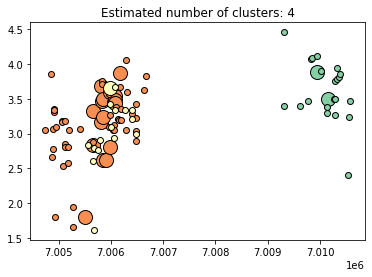

[ 1 -1  1 ...  0  0  0]
DBSCAN(eps=800, min_samples=30, n_jobs=20)
Estimated number of clusters: 4
Estimated number of noise points: 731
unique_labels = {0, 1, 2, 3, -1}


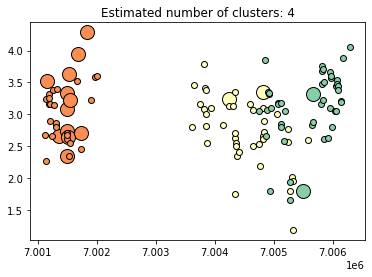

[-1 -1 -1 ...  0 -1 -1]
DBSCAN(eps=800, min_samples=50, n_jobs=20)
Estimated number of clusters: 5
Estimated number of noise points: 1827
unique_labels = {0, 1, 2, 3, 4, -1}


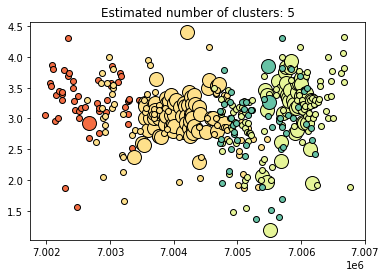

Search Complete. 
Your list is now of length 34. 
Hyperparameter combinations checked: 140. 

dbscan_clusters = [[50, 3, 28], [250, 15, 66], [300, 20, 6], [350, 25, 10], [400, 30, 15], [450, 35, 15], [500, 10, 91], [500, 15, 91], [500, 40, 28], [550, 10, 36], [550, 15, 45], [550, 20, 15], [550, 25, 36], [550, 50, 10], [600, 5, 91], [600, 10, 6], [600, 15, 36], [600, 20, 15], [600, 25, 6], [600, 30, 28], [600, 35, 91], [700, 5, 45], [700, 15, 15], [700, 20, 10], [700, 25, 6], [700, 35, 6], [700, 40, 15], [700, 50, 28], [800, 3, 78], [800, 5, 10], [800, 20, 6], [800, 25, 6], [800, 30, 6], [800, 50, 10]]


In [84]:
# Starting a tally of total iterations
n_iterations = 0

eps_space = [ 50,100,150,200,250,300,350,400,450,500,550,600,700,800]
min_samples_space = [3,5,10,15,20,25,30,35,40,50]

min_clust = 5
max_clust = 100
dbscan_clusters = []
clst_count = []

# Looping over each combination of hyperparameters
for eps_val in eps_space:
    for samples_val in min_samples_space:

        dbscan_grid = DBSCAN(eps = eps_val,
                            min_samples = samples_val,
                             n_jobs = 20)


        # fit_transform
        clusters = dbscan_grid.fit_predict(X = X)

        # Counting the amount of data in each cluster
        cluster_count = Counter(clusters)


        # Saving the number of clusters
        n_clusters = sum(abs(np.unique(clusters))) - 1


        # Increasing the iteration tally with each run of the loop
        n_iterations += 1


        # Appending the lst each time n_clusters criteria is reached
        if n_clusters >= min_clust and n_clusters <= max_clust:

            dbscan_clusters.append([eps_val,
                                    samples_val,
                                    n_clusters])


            clst_count.append(cluster_count)
            new_clst = DBSCAN(eps = eps_val,
                            min_samples = samples_val,
                             n_jobs = 20).fit(X)
            plot_model(new_clst,X)

# Printing grid search summary information
print(f"""Search Complete. \nYour list is now of length {len(clst_count)}. """)
print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

print("dbscan_clusters = {dbscan_clusters}".format(dbscan_clusters=dbscan_clusters))

[  7  10   7 ...  -1 136  -1]
DBSCAN(eps=300, n_jobs=20)
Estimated number of clusters: 144
Estimated number of noise points: 1129
unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, -1}


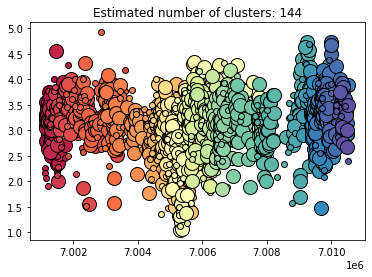

In [85]:
# Final model, pick one from above
clustering = DBSCAN(eps = 300,n_jobs = 20)#.fit(X)
clustering.fit(X)

plot_model(clustering,X)